# Titanic Survival

This python script is an attempt to replicate the amazingly detailed "Exploring Survival on the Titanic" Kernel produced by Megan Risdal on Kaggle in Python. The original script uses R to analyze, visualize, impute and predict. The entire thought process is entirely Megan's, and this is merely an attempt at reproducing the concept she uses in a different programming language.

Let's start by importing our necessary modules.

In [16]:
# Import necessary libraries
import pandas as pd  # Data Manipulation
import re  # Data Manipulation
import seaborn as sns  # Data Visualization
import matplotlib.pyplot as plt  # Data Visualization

%matplotlib inline

In [17]:
# Import Data
df_train = pd.read_csv("aaa_train.csv")
df_test = pd.read_csv("aaa_test.csv")
df_full = pd.concat([df_train, df_test], axis=0)

# Inspect Data.


In [18]:
print(df_full.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB
None



We can observe that we are working with 1309 observations of a total of 12 variables. While most of them are non-null, some have missing values: Age, Cabin, Embarked, and Fare. The survived column also has missing values, which is normal given that those are the values that we are trying to predict.
The above hints to the fact that some Feature Engineering will be necessary in order to fill in the missing values.

In [19]:
print(df_full.describe())


               Age         Fare        Parch  PassengerId       Pclass  \
count  1046.000000  1308.000000  1309.000000  1309.000000  1309.000000   
mean     29.881138    33.295479     0.385027   655.000000     2.294882   
std      14.413493    51.758668     0.865560   378.020061     0.837836   
min       0.170000     0.000000     0.000000     1.000000     1.000000   
25%      21.000000     7.895800     0.000000   328.000000     2.000000   
50%      28.000000    14.454200     0.000000   655.000000     3.000000   
75%      39.000000    31.275000     0.000000   982.000000     3.000000   
max      80.000000   512.329200     9.000000  1309.000000     3.000000   

             SibSp    Survived  
count  1309.000000  891.000000  
mean      0.498854    0.383838  
std       1.041658    0.486592  
min       0.000000    0.000000  
25%       0.000000    0.000000  
50%       0.000000    0.000000  
75%       1.000000    1.000000  
max       8.000000    1.000000  


Using summary statistics, we can observe that ~38% of people contained in the dataset survived the disaster. The average fare is 33, although the currency is unknown. For the purpose of the exercise, we will assume that the fares are all provided in Pounds, i.e. in the same currency. The standard deviation on the fare is high. We will analyze normality of different variables at later stages during the exercise.


In [20]:
print(df_full.head())

    Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket  
0       3    male      1       0.0         A/5 21171  
1       1  female      1       1.0          PC 17599  
2       3  female      0       1.0  STON/O2. 3101282  
3       1  female      1       1.0            113803  
4       3    male      0       0.0            373450  


When browsing the data, there are two specific items that come to mind. One is the names of the passengers. These contain a hidden variable, the title. We can parse the name of the Passengers to determine their title, and add this as a given feature of our dataset. This might create a risk of co-correlation between independent variables, since there would inherently be a correlation between their gender and title, but we can explore this at a later stage. The second item is the Cabin number. Even though the data is spotty, we can assume that most of Class I passengers had cabins, while Class III didn't. Also, the cabins seem named according to the cabin number, and the specific deck where the cabin was situated. Wgile I do not believe the cabin number will be valuable to our model, the deck might give us a bit more information as to the proximity to the lifeboats. We will explore this in more detail at a later stage.


# Visualize Data. 
Let's visualize!

C:\Users\adrie\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\adrie\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


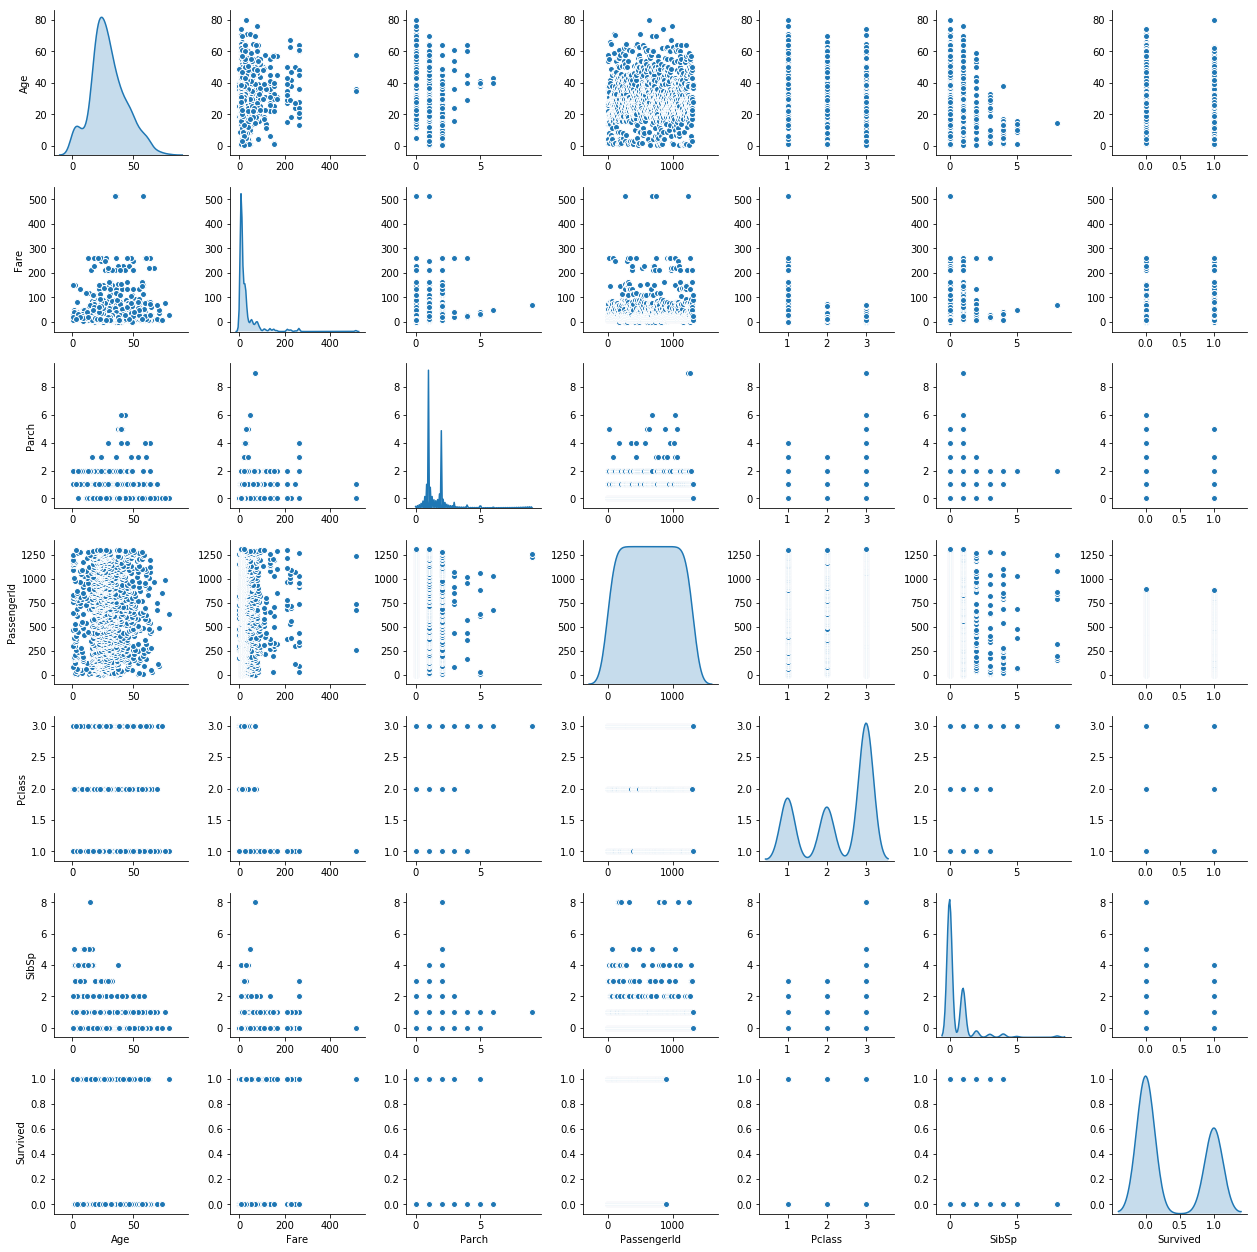

In [21]:
# First off, let's produce a scatterplot matrix of the data. Seaborn provides a handy function for this.
sns.pairplot(df_full, diag_kind="kde", diag_kws=dict(shade=True))

Visualizing the plot, there are three thoughts that come to mind. One is that we have a categorical variable represented in the PClass variable. This variable is presented as discrete and ordinal in the given Dataset, wo we will need to create dummy variables to ensure that we do not skew the model. Two is that the distribution of Fare is positively skewed, which will affect the model if we do not normalize the data. Three is that Passenger ID, if it was not made obvious by the inspection of the data above, will not yield any interesting information and is merely a list of numbers associated to the position of the Passenger within the Dataset.

In [22]:
# Let's drop Passenger ID from our Dataset.
df_full = df_full.drop('PassengerId', 1)

It is well known that during the incident, women and children were prioritized to board the safety boats. Let's verify this.

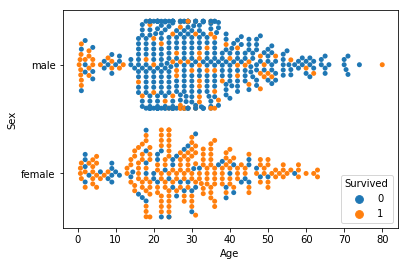

In [23]:
# Scatter plot of age, sex and Survived (presented in hue)

sns.swarmplot(x="Age", y="Sex", hue="Survived", data=df_train)

The swarmplot shows a clear correlation between age, sex, and whether or not passengers survived. From the scatterplot matrix that we had above, it also appears that we have a correlation between fare and survived. Let's visulize that.


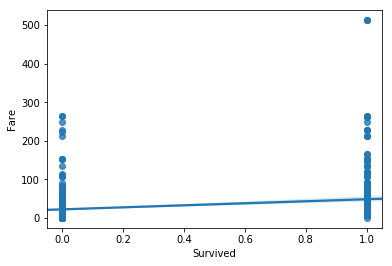

In [24]:
sns.regplot(x="Survived", y="Fare", data=df_train)

Although there does seem to be a correlation, the slope does not seem very high.
At this point, we have identified three variables that may have an impact on whether or not the passenger survived: 1) Sex, 2) Age, 3) Fare.
Can we find others? Let's do some Feature Engineering!

# Feature Engineering - Part 1, Titles.
Fortunately, title extraction is made easy by the fact the they are standardized (i.e. contained in between a comma and a dot).

In [25]:
df_full["Title"] = df_full["Name"].str.replace("(.*, )|(\..*)", "")

Now, let's count the number of Passengers for each title, per sex.

In [26]:
print(df_full.groupby(["Sex", "Title"]).agg({"Name": ["count"]}))

                     Name
                    count
Sex    Title             
female Dona             1
       Dr               1
       Lady             1
       Miss           260
       Mlle             2
       Mme              1
       Mrs            197
       Ms               2
       the Countess     1
male   Capt             1
       Col              4
       Don              1
       Dr               7
       Jonkheer         1
       Major            2
       Master          61
       Mr             757
       Rev              8
       Sir              1


Some of these titles are not interesting because they have few values. We can replace them.

               Name
              count
Sex    Title       
female Miss     264
       Mrs      198
       Other      4
male   Master    61
       Mr       758
       Other     24


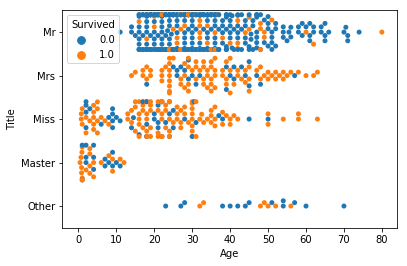

In [27]:
replace_strings = {"Dona": "Other", "Lady": "Other", "the Countess": "Other", "Capt": "Other", "Don": "Other", "Jonkheer": "Other", "Major": "Other", "Mlle": "Miss", "Mme": "Mrs", "Ms": "Miss", "Sir": "Mr", "Dr": "Other", "Rev": "Other", "Col": "Other"}
df_full["Title"] = df_full["Title"].replace(replace_strings)

# This leaves us with fewer titles to work with.
print(df_full.groupby(["Sex", "Title"]).agg({"Name": ["count"]}))
sns.swarmplot(x="Age", y="Title", hue="Survived", data=df_full)


All right. It looks like again, age and survival are connected. Titles assigned to younger individuals ("Master" and "Miss") have a higher overall chance of survival.
Onto the decks. Let's split the deck from the Cabin number.

    Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  Pclass     Sex  \
0                            Braund, Mr. Owen Harris      0       3    male   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0       1  female   
2                             Heikkinen, Miss. Laina      0       3  female   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0       1  female   
4                           Allen, Mr. William Henry      0       3    male   

   SibSp  Survived            Ticket Title Pdeck  
0      1       0.0         A/5 21171    Mr   NaN  
1      1       1.0          PC 17599   Mrs     C  
2      0       1.0  STON/O2. 3101282  Miss   NaN  
3      1       1.0            113803   Mrs     C  
4      0       0.0            373450    Mr   NaN  


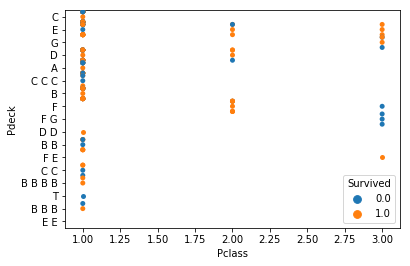

In [28]:
df_full["Pdeck"] = df_full["Cabin"].str.replace("[0-9]", "")
print(df_full.head())

sns.swarmplot(x="Pclass", y="Pdeck", hue="Survived", data=df_full)
